In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils import resample
import math as math


In [59]:

sns.set(rc={'figure.figsize':(11.7,9)})

In [4]:
Data = pd.read_csv('House_Price_Regression.csv')

Data = Data.loc[:, ['latitude', 'longitude', 'price', 'size_in_m_2']]

Data.head()

,latitude,longitude,price,size_in_m_2
0,25.113208,55.138932,2700000,100.242337
1,25.106809,55.151201,2850000,146.972546
2,25.063302,55.137728,1150000,181.253753
3,25.227295,55.341761,2850000,187.664060
4,25.114275,55.139764,1729200,47.101821


In [5]:
Data_numpy = Data.to_numpy()

## Distancias

In [6]:
def Dist_Euclidea(x_i, x_r):

        Dist_Euclidea = ( ( x_i - x_r )**2 ).sum()

        Dist_Euclidea = np.sqrt(Dist_Euclidea)

        return Dist_Euclidea

In [7]:
def Matrix_Dist_Euclidea(Data):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Euclidea(Data[i,:] , Data[r,:])   

                      
    return M 

In [8]:
def Dist_Minkowski(x_i, x_r, q):

    Dist_Minkowski = ( ( ( abs( x_i - x_r) )**q ).sum() )**(1/q)

    return Dist_Minkowski

In [9]:
def Matrix_Dist_Minkowski(Data, q):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Minkowski(Data[i,:] , Data[r,:], q)   

                      
    return M 

In [10]:
def Dist_Canberra(x_i, x_r):

    numerator =  abs( x_i - x_r )

    denominator =  ( abs(x_i) + abs(x_r) )
       
    numerator=np.array([numerator], dtype=float)

    denominator=np.array([denominator], dtype=float)

    # The following code is to eliminate zero division problems

    Dist_Canberra = ( np.divide( numerator , denominator , out=np.zeros_like(numerator), where=denominator!=0) ).sum() 

    return Dist_Canberra

In [11]:
def Matrix_Dist_Canberra(Data):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Canberra(Data[i,:] , Data[r,:])   

                      
    return M 

In [12]:
def Dist_Mahalanobis_2(x_i, x_r, S_inv):  # Más eficiente que la anterior

    # All the columns of Data must be type = 'float' or 'int' (specially not 'object'), in other case we will find 
    # dimensional problems when Python compute   x @ S_inv @ x.T

    x = (x_i - x_r)
    
    # x = np.array([x]) 
    
    # En este caso este paso no será necesario por el tipo de estructura Python (una lista) que va a ser un medoid en el
    # algoritmo que a continuación definiremos. De hecho si este paso no se suprimer salta un error al usar la distancia
    # de Mahalanobis, puesto que la operacion x @ S_inv @ x.T no está bien definida.

    Dist_Maha = np.sqrt( x @ S_inv @ x.T )  # x @ S_inv @ x.T = np.matmul( np.matmul(x , S_inv) , x.T )

    Dist_Maha = float(Dist_Maha)

    return Dist_Maha

In [13]:
def Dist_Mahalanobis_3(x, S_inv):  # Más eficiente que la anterior

    # All the columns of Data must be type = 'float' or 'int' (specially not 'object'), in other case we will find 
    # dimensional problems when Python compute   x @ S_inv @ x.T

    # x = (x_i - x_r)

    # x = np.array([x]) # necessary step to transpose a 1D array

    Dist_Maha = np.sqrt( x @ S_inv @ x.T )  # x @ S_inv @ x.T = np.matmul( np.matmul(x , S_inv) , x.T )

    Dist_Maha = float(Dist_Maha)

    return Dist_Maha

In [14]:
def Matrix_Dist_Mahalanobis_3(Data):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    S_inv=np.linalg.inv( np.cov(Data , rowvar=False) )

   
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Mahalanobis_3(x = np.array([Data[i,:] - Data[r,:]]) , S_inv=S_inv ) 

                      
    return M 

In [15]:
def a_b_c_d_Matrix(Data):

    X = Data

    a = X @ X.T

    n = X.shape[0]

    p = X.shape[1]

    ones_matrix = np.ones((n, p)) 

    b = (ones_matrix - X) @ X.T

    c = b.T

    d = (ones_matrix - X) @ (ones_matrix - X).T

    return a , b , c , d , p

In [16]:
def alpha(x_i, x_r):

    alpha = sum(x_i == x_r)

    return(alpha)

In [17]:
def Matrix_Gower_Similarity(Data, p1, p2, p3 ):

    # Data tiene que ser un numpy array tal que:
    # las primeras p1 tiene que ser variables cuantitativas, 
    # las siguientes p2 binarias y las restantes p3 multicales

    # Si Data no contiene variables cuantitativas --> p1=0
    # Si Data no contiene variables binarias --> p2=0
    # Si Data no contiene variables multiclase --> p3=0

    n = len(Data)

    M =  np.empty((n , n))

############################################################
    
    G_vector = np.repeat(0.5, p1)

    for k in range(0, p1):

        G_vector[k] = Data[:,k].max() - Data[:,k].min()

############################################################
   
    ones = np.repeat(1, p1)

    Quant_Data = Data[: , 0:p1]

    Binary_Data = Data[: , (p1):(p1+p2)]

    Multiple_Data = Data[: , (p1+p2):(p1+p2+p3) ]

############################################################

    a, b, c, d, p = a_b_c_d_Matrix(Binary_Data)

############################################################

    for i in range(0, n):

         for r in range(0, n):

            if i > r :
               
                 M[i,r] = 0
            
            elif i == r :
               
                 M[i,r] = 1
            
            else :

                # Calculo de la distancia de Gower entre las observaciones x_i y x_r

                numerator_part_1 = ( ones - ( abs(Quant_Data[i,:] - Quant_Data[r,:]) / G_vector ) ).sum() 

                numerator_part_2 = a[i,r] + alpha(Multiple_Data[i,:], Multiple_Data[r,:])

                numerator = numerator_part_1 + numerator_part_2
                

                if p1 + (p2 - d[i,r]) + p3 == 0:

                    M[i,r] = 0

                else:
                    
                    denominator = p1 + (p2 - d[i,r]) + p3

                    M[i,r] = numerator / denominator
                      
   
    return M  

In [18]:
def Matrix_Gower_Distance(Data, p1, p2, p3 ):

    M = Matrix_Gower_Similarity(Data, p1, p2, p3)

    M = M + M.T - np.diag(np.repeat(1 , len(M)), k=0)

    M = np.sqrt( 1 - M )

    return M

## K-medoids de Park y Jun modificando la definicion de los clusters iniciales

In [24]:
def k_medoids(Data, Distance_function, q, S_inv, Distance_Matrix, random_seed, k, max_n_iter):

    # Data --> a numpy array
    # Distance_function --> a distance function betwwen arrays
    # q --> parametro necesario si se usa la distancia Minkowski
    # S_inv --> parametro necesario si se usa la distancia Mahalanobis
    # Distance_Matriz --> a distance matrix (en forma completa)
    # random_seed --> semilla aleatoria
    # k --> nº clusters
    # max_n_iter --> nº maximo de iteraciones del algoritmo

###########################################################################################

    lista_df_clusters_finales_iter = []

###########################################################################################

# Se generan los clusters iniciales aleatoreamente

    sample = resample(range(0, len(Data)), n_samples=len(Data), replace=False, random_state=random_seed)

    df_sample = pd.DataFrame({'index': range(0,len(Data)) , 'sample':sample})

    Q = []

    for q in np.arange(0 , 1 + 1/k , 1/k):

        Q.append( np.quantile( range(0, len(Data)) , q ).round(0) )



    labels_clusters = np.array([0])

    for j in range(0,k):
   
        labels_clusters = np.concatenate([labels_clusters, np.repeat( j, len( df_sample.loc[Q[j]:(math.floor(Q[j+1])-1), 'sample'] ) ) ] ) 
 

    df_cluster = pd.DataFrame({'observacion': df_sample['sample'] , 'cluster': labels_clusters})

    lista_df_clusters_finales_iter.append(df_cluster)

###########################################################################################


# calculamos los medoids de los clusters iniciales

    M = Distance_Matrix

   ######################

    medoids = []
    label_medoids =[]

    for j in range(0, k):

      observations_cluster_j = df_cluster.loc[df_cluster.cluster == j ,].observacion

      M_j = M[observations_cluster_j, :][: ,observations_cluster_j] # matriz distancias para el cluster j

      suma_distancias = M_j.sum(axis=1) # suma de la matriz por filas

      h = np.where( suma_distancias == min( suma_distancias ) ) # indice en la matriz de la observacion que minimiza la suma de distancias en el cluster j --> medoid del cluster j

      d = df_cluster.loc[df_cluster.cluster == j , ]    

      # d.iloc[h[0],:].observacion es el indice en el data set original de la observacion medoid del cluster j 


      if len(h[0]) == 1 : 
        
        medoids.append( Data[ d.iloc[h[0],:].observacion , : ]  ) # su componente j es el medoid del cluster j

        label_medoids.append(d.iloc[h[0],:].observacion)

      if len(h[0]) > 1 : 
        
        medoids.append( Data[ int(d.iloc[h[0][0],:].observacion)  , : ]  ) # su componente j es el medoid del cluster j

        label_medoids.append( int(d.iloc[h[0][0],:].observacion) )

      # Los condicionales son para evitar problemas en el caso de que en un cluster haya mas de un medoid.
      # Puede haber dos o mas observaciones que cumplan con la definicion de medoid, para alguno de los clusters.
      # Si un cluster tiene varios medoids, nos quedamos solo con uno.

###########################################################################################


   # Calculamos la suma de varianzas intra cluster para los clusters iniciales

    lista_suma_varianzas_intra_cluster = []

    distancias, varianzas_intra_cluster , suma_varianzas_intra_cluster = [], [], []

    for j in range(0,k):

        for i in df_cluster.loc[df_cluster.cluster == j, 'observacion']:

            if Distance_function == Dist_Euclidea : distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

            if Distance_function == Dist_Minkowski : distancias.append( Distance_function( Data[i,:] , medoids[j] , q ) )

            if Distance_function == Dist_Canberra : distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

            # if Distance_function == Dist_Mahalanobis_2: distancias.append( Distance_function( Data[i,:] , medoids[j] , S_inv) )

            if Distance_function == Dist_Mahalanobis_2 :  distancias.append( Distance_Matrix[ i , label_medoids[j] ] )
            
            if Distance_function == 'Dist_Gower' :  distancias.append( Distance_Matrix[ i , label_medoids[j] ] )
            

        varianzas_intra_cluster.append( sum(distancias) )


    suma_varianzas_intra_cluster.append( sum(varianzas_intra_cluster) )

    lista_suma_varianzas_intra_cluster.append( suma_varianzas_intra_cluster )


###########################################################################################


# Asignar cada observacion a su cluster más cercano 


    for r in range(0 , max_n_iter):


       # Calculamos los nuevos clusters 

        labels_clusters = []

        for i in df_sample['sample']:

            distancias = []
    
            for j in range(0,k):

                if Distance_function == Dist_Euclidea: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

                if Distance_function == Dist_Minkowski: distancias.append( Distance_function( Data[i,:] , medoids[j] , q ) )

                if Distance_function == Dist_Canberra: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

                # if Distance_function == Dist_Mahalanobis_2: distancias.append( Distance_function( Data[i,:] , medoids[j] , S_inv) )

                if Distance_function == Dist_Mahalanobis_2 :  distancias.append( Distance_Matrix[ i , label_medoids[j] ] )
            
                if Distance_function == 'Dist_Gower' :  distancias.append( Distance_Matrix[ i , label_medoids[j] ] )

                

            df_distancias = pd.DataFrame({'Distancias' : distancias , 'Cluster': range(0,k)})

            df_distancias_sort = df_distancias.sort_values(by='Distancias', ascending=True)

            labels_clusters.append( df_distancias_sort.iloc[0]['Cluster'] )

        
        
        df_cluster = pd.DataFrame({'observacion' : df_sample['sample'] , 'cluster': labels_clusters})


###########################################################################################


       # Calculamos los medoids de los nuevos clusters

        medoids = []
        label_medoids =[]


        for j in range(0, k):                    
                
                observations_cluster_j = df_cluster.loc[df_cluster.cluster == j ,].observacion

                M_j = M[observations_cluster_j, :][: ,observations_cluster_j] # matriz distancias para el cluster j

                suma_distancias = M_j.sum(axis=1) # suma de la matriz por filas

                h = np.where( suma_distancias == min( suma_distancias) ) # indice en la matriz de la observacion que minimiza la suma de distancias en el cluster j --> medoid del cluster j

                d = df_cluster.loc[df_cluster.cluster == j , ]    

                # d.iloc[h[0],:].observacion  es el indice en el data set original de la observacion medoid del cluster j 
                
                if len(h[0]) == 1 : 
                    
                    medoids.append( Data[ d.iloc[h[0],:].observacion , : ]  )   # su componente j es el medoid del cluster j

                    label_medoids.append(d.iloc[h[0],:].observacion)


                elif len(h[0]) > 1 : 
                  
                    medoids.append( Data[ int(d.iloc[h[0][0], :].observacion)  , : ]  ) # su componente j es el medoid del cluster j
                
                    label_medoids.append( int(d.iloc[h[0][0], :].observacion) )
                
                # Los condicionales son para evitar problemas en el caso de que en un cluster haya mas de un medoid.
                # Puede haber dos o mas observaciones que cumplan con la definicion de medoid, para alguno de los clusters.
                # Si un cluster tiene varios medoids, nos quedamos solo con uno.

###########################################################################################

        # Calculamos la suma de varianzas intra cluster para los nuevos clusters

        distancias, varianzas_intra_cluster , suma_varianzas_intra_cluster = [], [], []

        for j in range(0,k):

            for i in df_cluster.loc[df_cluster.cluster == j, 'observacion']:

                if Distance_function == Dist_Euclidea: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

                if Distance_function == Dist_Minkowski: distancias.append( Distance_function( Data[i,:] , medoids[j] , q ) )

                if Distance_function == Dist_Canberra: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

                # if Distance_function == Dist_Mahalanobis_2: distancias.append( Distance_function( Data[i,:] , medoids[j] , S_inv) )

                if Distance_function == Dist_Mahalanobis_2 :  distancias.append( Distance_Matrix[ i , label_medoids[j] ] )

                if Distance_function == 'Dist_Gower' :  distancias.append( Distance_Matrix[ i , label_medoids[j] ] )

            varianzas_intra_cluster.append( sum(distancias) )


        suma_varianzas_intra_cluster.append( sum(varianzas_intra_cluster) )

        lista_suma_varianzas_intra_cluster.append( suma_varianzas_intra_cluster )

    ###########################################

        df_clusters_finales_iter = pd.DataFrame({'observaciones': df_sample['sample']  , 'cluster': labels_clusters })

        lista_df_clusters_finales_iter.append(df_clusters_finales_iter)

######################################################################################
######################################################################################

    from itertools import chain

    # unlist a list:

    if Distance_function in ['Dist_Gower', Dist_Mahalanobis_2] :

        lista_suma_varianzas_intra_cluster = list(chain.from_iterable(lista_suma_varianzas_intra_cluster))

        lista_suma_varianzas_intra_cluster = list(chain.from_iterable(lista_suma_varianzas_intra_cluster))

        df_suma_varianzas_intra_cluster = pd.DataFrame({'sum_var_intra_cluster':lista_suma_varianzas_intra_cluster  , 'iter': range(0, max_n_iter+1)})
    
        sort_df_suma_varianzas_intra_cluster = df_suma_varianzas_intra_cluster.sort_values(by='sum_var_intra_cluster', ascending=True)
   

    else :

        lista_suma_varianzas_intra_cluster = list(chain.from_iterable(lista_suma_varianzas_intra_cluster))

        df_suma_varianzas_intra_cluster = pd.DataFrame({'sum_var_intra_cluster':lista_suma_varianzas_intra_cluster  , 'iter': range(0, max_n_iter+1)})
    
        sort_df_suma_varianzas_intra_cluster = df_suma_varianzas_intra_cluster.sort_values(by='sum_var_intra_cluster', ascending=True)

    

    df_clusters_optimos = lista_df_clusters_finales_iter[ sort_df_suma_varianzas_intra_cluster.iloc[0,1] ]

    # Nos quedamos con la configuración de clusters óptima. Aquella con la que se obtiene menor suma de varianzas intra-cluster
    

######################################################################################

    return df_clusters_optimos, lista_df_clusters_finales_iter , sort_df_suma_varianzas_intra_cluster,  df_suma_varianzas_intra_cluster


### Prueba con la distancia Euclidea

In [115]:
Distance_Matrix = Matrix_Dist_Euclidea(Data_numpy)

In [116]:
Distance_Matrix = Distance_Matrix + Distance_Matrix.T

In [117]:
lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster = k_medoids(Data=Data_numpy , Distance_function=Dist_Euclidea, q=1, S_inv='none', Distance_Matrix=Distance_Matrix, random_seed=123, k=4, max_n_iter=50)


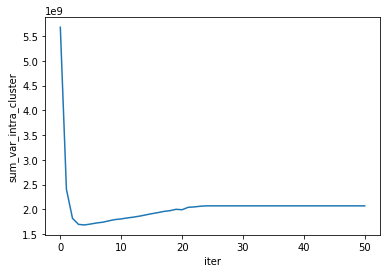

In [118]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [119]:
sort_df_suma_varianzas_intra_cluster.head(7)

,sum_var_intra_cluster,iter
4,1.683331e+09,4
3,1.693215e+09,3
5,1.701915e+09,5
6,1.723348e+09,6
7,1.738627e+09,7
8,1.766953e+09,8
9,1.791426e+09,9


In [120]:
lista_df_clusters_finales_iter[4]

,observaciones,cluster
0,382,3.0
1,732,2.0
2,1888,1.0
3,679,1.0
4,1004,3.0
...,...,...
1900,1122,0.0
1901,1346,1.0
1902,1406,0.0
1903,1389,2.0


### Prueba distancia Minkowski

In [121]:
Distance_Matrix = Matrix_Dist_Minkowski(Data_numpy , q=1)

In [122]:
Distance_Matrix = Distance_Matrix + Distance_Matrix.T

In [123]:
lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster = k_medoids(Data=Data_numpy , Distance_function=Dist_Minkowski, q=1, S_inv='none', Distance_Matrix=Distance_Matrix, random_seed=123, k=4, max_n_iter=50)


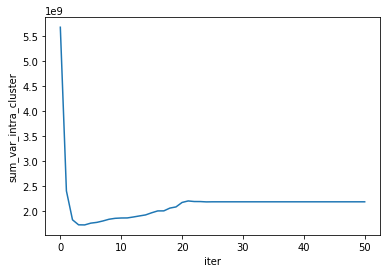

In [124]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [125]:
sort_df_suma_varianzas_intra_cluster.head(7)

,sum_var_intra_cluster,iter
4,1.725662e+09,4
3,1.727426e+09,3
5,1.760959e+09,5
6,1.776527e+09,6
7,1.804786e+09,7
2,1.827944e+09,2
8,1.838981e+09,8


In [126]:
lista_df_clusters_finales_iter[4]

,observaciones,cluster
0,382,3.0
1,732,1.0
2,1888,2.0
3,679,2.0
4,1004,3.0
...,...,...
1900,1122,0.0
1901,1346,2.0
1902,1406,0.0
1903,1389,1.0


### Prueba con Distancia Canberra

In [127]:
Distance_Matrix = Matrix_Dist_Canberra(Data_numpy)

Distance_Matrix = Distance_Matrix + Distance_Matrix.T

In [128]:
lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster = k_medoids(Data=Data_numpy , Distance_function=Dist_Canberra, q=1, S_inv='none', Distance_Matrix=Distance_Matrix, random_seed=123, k=4, max_n_iter=50)


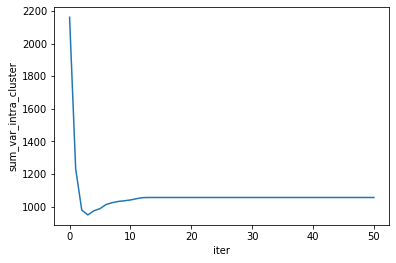

In [129]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [130]:
sort_df_suma_varianzas_intra_cluster.head(7)

,sum_var_intra_cluster,iter
3,948.995737,3
4,974.342062,4
2,978.890348,2
5,987.711504,5
6,1012.867292,6
7,1024.034138,7
8,1031.668554,8


In [131]:
lista_df_clusters_finales_iter[3]

,observaciones,cluster
0,382,3.0
1,732,2.0
2,1888,0.0
3,679,0.0
4,1004,3.0
...,...,...
1900,1122,0.0
1901,1346,0.0
1902,1406,1.0
1903,1389,2.0


### Prueba Distancia Mahalanobis

In [170]:
S_inv = np.linalg.inv( np.cov(Data_numpy , rowvar=False) )

In [171]:
Distance_Matrix = Matrix_Dist_Mahalanobis_3(Data_numpy)

Distance_Matrix = Distance_Matrix + Distance_Matrix.T

In [25]:
lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster  = k_medoids(Data=Data_numpy , Distance_function=Dist_Mahalanobis_2, q=1, S_inv=S_inv, Distance_Matrix=Distance_Matrix, random_seed=123, k=4, max_n_iter=50)


NameError: name 'S_inv' is not defined

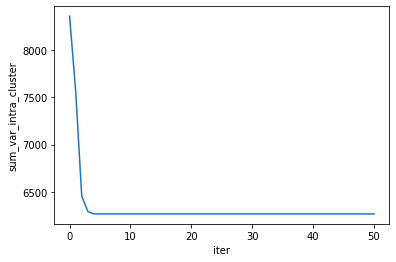

In [188]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [189]:
sort_df_suma_varianzas_intra_cluster.head(7)

,sum_var_intra_cluster,iter
25,6267.000431,25
27,6267.000431,27
28,6267.000431,28
29,6267.000431,29
30,6267.000431,30
31,6267.000431,31
32,6267.000431,32


### Prueba distancia Gower

In [21]:
Data = pd.read_csv('House_Price_Regression.csv')

Data_mixed = Data.loc[:, ['latitude', 'longitude', 'price', 'size_in_m_2', 'balcony_recode', 'private_garden_recode', 'quality_recode']]

Data_mixed_numpy = Data_mixed.to_numpy()

M_Gower = Matrix_Gower_Distance(Data=Data_mixed_numpy, p1=4, p2=2, p3=1)

In [26]:
df_clusters_optimos, lista_df_clusters_finales_iter, sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster  = k_medoids(Data=Data_mixed_numpy , Distance_function='Dist_Gower', q=1, S_inv='no', Distance_Matrix=M_Gower, random_seed=123, k=4, max_n_iter=50)

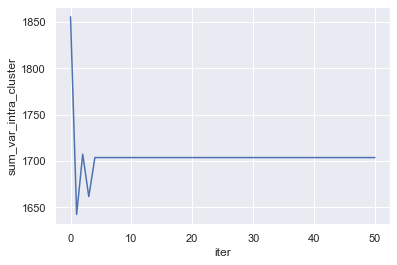

In [27]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [378]:
sort_df_suma_varianzas_intra_cluster.head(7)

,sum_var_intra_cluster,iter
1,1642.528876,1
3,1661.694982,3
25,1703.841063,25
28,1703.841063,28
29,1703.841063,29
30,1703.841063,30
31,1703.841063,31


In [29]:
df_clusters_optimos_Gower = df_clusters_optimos

## Bagging + k-medoids

In [360]:
def kmedoids_ensemble(Data, k , size, B, random_seed_1=111, max_n_iter=30, random_seed_2=123):

    Distance_function='Dist_Gower'; q=1; S_inv='no' ; random_seed=random_seed_2

    n = len(Data)

    df_clusters = pd.DataFrame()

    sample_1 = resample(range(0, n), n_samples=n , replace=False, random_state=random_seed_1)

    
    
    for j in range(0, B):

        sample = resample(sample_1, n_samples=size , replace=False, random_state=j)

        Distance_Matrix = Matrix_Gower_Distance(Data[sample,:] ,  p1=4, p2=1, p3=1)

        df_clusters_optimos, lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster = k_medoids(Data[sample,:] , Distance_function, q, S_inv, Distance_Matrix, random_seed, k, max_n_iter)

        df_clusters = pd.concat([df_clusters , pd.DataFrame({'observacion':sample , 'cluster': df_clusters_optimos.cluster })] , ignore_index=True)



    lista_clusters_finales = []

    observaciones_usadas = df_clusters.observacion.unique() 

    observaciones_no_usadas = list(set(range(0,n)) - set( df_clusters.observacion.unique() ) )

    prop_observaciones_no_usadas = len(observaciones_no_usadas) / n

    for i in observaciones_usadas :

        a = df_clusters.loc[ df_clusters['observacion']==i , 'cluster']

        unique, counts = np.unique(a , return_counts=True)

        b = pd.DataFrame({'cluster':unique , 'counts':counts})

        c = b.sort_values(by=["counts"], ascending=False).iloc[0,:]['cluster']

        lista_clusters_finales.append(c)


    df_clusters_finales = pd.DataFrame({'observacion' : observaciones_usadas  , 'cluster_final' : lista_clusters_finales })

    return df_clusters_finales , prop_observaciones_no_usadas

In [361]:
df_clusters_finales , prop_observaciones_no_usadas = kmedoids_ensemble(Data=Data_mixed_numpy, k=4 , size=50, B=100, random_seed_1=111, max_n_iter=30, random_seed_2=123)

Tarda 2.41 mins , bastante más que el algoritmo sin ensemble. No tiene mucho sentido.

In [362]:
df_clusters_finales

,observacion,cluster_final
0,6,0
1,415,1
2,484,0
3,1104,1
4,624,2
...,...,...
1765,1749,3
1766,83,1
1767,850,2
1768,1412,3


In [363]:
prop_observaciones_no_usadas

0.07086614173228346

## k-medoids con libreria `kmedoids` de Python

In [366]:
import kmedoids

In [364]:
M_Gower = Matrix_Gower_Distance(Data=Data_mixed_numpy, p1=4, p2=2, p3=1)

In [367]:
k_medoids_libreria_1 = kmedoids.alternating(diss=M_Gower , medoids=4 , max_iter=100, init='random', random_state=123)

In [369]:
k_medoids_libreria_1.labels

array([2, 2, 2, ..., 2, 2, 3], dtype=uint64)

In [371]:
k_medoids_libreria_1.medoids

array([1309, 1263,  714,  984], dtype=uint64)

In [375]:
Data_Clusters = pd.concat( [ pd.DataFrame( {'Clusters' : k_medoids_libreria_1.labels} ) , Data_mixed  ], axis=1 )
Data_Clusters

,Clusters,latitude,longitude,price,size_in_m_2,balcony_recode,private_garden_recode,quality_recode
0,2,25.113208,55.138932,2700000,100.242337,1.0,0.0,2.0
1,2,25.106809,55.151201,2850000,146.972546,1.0,0.0,2.0
2,2,25.063302,55.137728,1150000,181.253753,1.0,0.0,2.0
3,1,25.227295,55.341761,2850000,187.664060,1.0,0.0,1.0
4,0,25.114275,55.139764,1729200,47.101821,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...
1900,3,25.176892,55.310712,1500000,100.985561,1.0,0.0,3.0
1901,2,25.166145,55.276684,1230000,70.606280,1.0,0.0,2.0
1902,2,25.206500,55.345056,2900000,179.302790,1.0,0.0,2.0
1903,2,25.073858,55.229844,675000,68.748220,1.0,1.0,2.0


## k-medoids con libreria + ensemble

In [393]:
def kmedoids_ensemble(Data, k , size, B, random_seed_1, random_seed_2=123):

    n = len(Data)

    df_clusters = pd.DataFrame()

    sample_1 = resample(range(0, n), n_samples=n , replace=False, random_state=random_seed_1)

    for j in range(0, B):

        sample = resample(sample_1, n_samples=size , replace=False, random_state=j)

        M = Matrix_Gower_Distance(Data[sample,:] ,  p1=4, p2=1, p3=1)

        k_medoids = kmedoids.alternating(diss=M , medoids=k , max_iter=100, init='random', random_state=random_seed_2)

        df_clusters = pd.concat([df_clusters , pd.DataFrame({'observacion':sample , 'cluster':k_medoids.labels })] , ignore_index=True)

    lista_clusters_finales = []

    observaciones_usadas = df_clusters.observacion.unique() 

    observaciones_no_usadas = list(set(range(0,n)) - set( df_clusters.observacion.unique() ) )

    prop_observaciones_no_usadas = len(observaciones_no_usadas) / n

    for i in observaciones_usadas :

        a = df_clusters.loc[ df_clusters['observacion']==i , 'cluster']

        unique, counts = np.unique(a , return_counts=True)

        b = pd.DataFrame({'cluster':unique , 'counts':counts})

        c = b.sort_values(by=["counts"], ascending=False).iloc[0,:]['cluster']

        lista_clusters_finales.append(c)


    df_clusters_finales = pd.DataFrame({'observacion' : observaciones_usadas  , 'cluster_final' : lista_clusters_finales })

    return df_clusters_finales , prop_observaciones_no_usadas

In [394]:
df_clusters_finales , prop_observaciones_no_usadas = kmedoids_ensemble( Data=Data_mixed_numpy, k=4 , size=100, B=200, random_seed_1=123, random_seed_2=123)

In [395]:
df_clusters_finales

,observacion,cluster_final
0,161,0.0
1,1516,1.0
2,1094,0.0
3,1457,0.0
4,1610,0.0
...,...,...
1900,1123,2.0
1901,1327,0.0
1902,849,0.0
1903,105,3.0


In [396]:
prop_observaciones_no_usadas

0.0

## Shiloutte

In [30]:
df_clusters_optimos_Gower

,observaciones,cluster
0,382,0
1,732,0
2,1888,2
3,679,3
4,1004,1
...,...,...
1900,1122,0
1901,1346,1
1902,1406,3
1903,1389,0


In [31]:
def f(i,h):

    f_i_h_list = []

    C_h = df_clusters_optimos_Gower.loc[df_clusters_optimos_Gower.cluster == h , :]

    for r in C_h.observaciones :

        f_i_h_list.append( M_Gower[i , r] )

    f_i_h = sum(f_i_h_list)/len(C_h)  # distancia media entre x_i y el cluster C_h


    return f_i_h

In [32]:
f(i=382 , h=0)  # sabemos que la observacion i=382 pertenece al C_0

0.6706691121223523

In [432]:
f(i=382 , h=2) 

0.7305875510369139

In [37]:
k=4

In [38]:
def b(i):

    for h in range(0,k):

            C_h = df_clusters_optimos_Gower.loc[df_clusters_optimos_Gower.cluster == h , :]


            if i in C_h.observaciones :

                b_i = f(i,h)
    
    return b_i

In [435]:
b(i=382)  # sabemos que la observacion i=382 pertenece al C_0

0.6706691121223523

In [436]:
f(i=382 , h=0) 

0.6706691121223523

In [39]:
def a(i):

    a_i_list = []

    for h in range(0,k):

            C_h = df_clusters_optimos_Gower.loc[df_clusters_optimos_Gower.cluster == h , :]


            if i in C_h.observaciones :

                for j in range(0,k):

                    if j != h :

                        a_i_list.append( f(i,j) )

                a_i = min(a_i_list)
    
    return a_i

In [442]:
a(i=382) 

0.7042859423721816

In [40]:
def silhouette(i) :

   s_i = ( a(i) - b(i) ) / max( [a(i) , b(i)] )

   return s_i


In [49]:
silhouette(i=382)

0.04773179219877772

In [51]:
s_i_list = []

for i in df_clusters_optimos.observaciones :

    s_i_list.append(silhouette(i))

In [52]:
silhouette_media =  sum(s_i_list)/len(s_i_list)

silhouette_media

-0.09246510262385878

In [53]:
df_silhouette = pd.DataFrame({'silhouette':s_i_list , 'observacion':df_clusters_optimos.observaciones , 'cluster':df_clusters_optimos.cluster})

In [54]:
df_silhouette

,silhouette,observacion,cluster
0,0.047732,382,0
1,-0.041635,732,0
2,-0.326993,1888,2
3,-0.015526,679,3
4,-0.313090,1004,1
...,...,...,...
1900,-0.058187,1122,0
1901,-0.013150,1346,1
1902,-0.104993,1406,3
1903,-0.001513,1389,0


In [55]:
df_silhouette_sort = df_silhouette.sort_values(by='cluster')

In [71]:
df_silhouette_sort.cluster = df_silhouette_sort.cluster.astype('category')

In [96]:
df_silhouette_sort

,silhouette,observacion,cluster
0,0.047732,382,0
912,-0.020184,1819,0
914,-0.077847,1461,0
915,-0.000939,712,0
916,-0.046624,1477,0
...,...,...,...
906,-0.105955,1035,3
901,-0.026890,1737,3
1418,-0.271076,1225,3
1409,0.066014,419,3


In [62]:
import matplotlib as mpl
import matplotlib.pyplot as plt

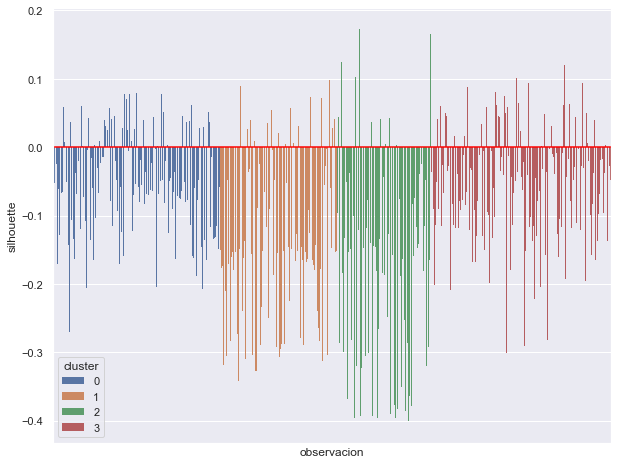

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))

plot = sns.barplot(data=df_silhouette_sort, y='silhouette' , x='observacion', order=df_silhouette_sort.observacion, hue='cluster', dodge=False, lw=0)

plot.set_xticks([ ])

plot.axhline(0, color='red')